In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import math
import matplotlib
import pandas
import glob
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [3]:
from diameter_tools import get_trunk_diam

In [4]:
def load_data() -> pandas.DataFrame:
    a = glob.glob('data/*.csv')

    data = None
    l = []
    for f in a:
        dataset = pandas.read_csv(f)
        l.append(dataset)
    data = pandas.concat(l)
    return data

data = load_data()


/home/sir/.virtualenvs/tree/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [5]:
data['norm'] = data['Obwód pnia w cm'].fillna('0')
data.dropna(subset=['Obwód pnia w cm', 'norm',], inplace=True)
data['norm'] = data['norm'].apply(pandas.Series)

In [6]:
data['normalized_trunk_diam'] = data['norm'].apply(get_trunk_diam)
# data['normalized_trunk_diam'] = data['normalized_trunk_diam'] / 100

34 malformed node or string: 34 <class 'int'>
32 malformed node or string: 32 <class 'int'>
38 malformed node or string: 38 <class 'int'>
8 malformed node or string: 8 <class 'int'>
40 malformed node or string: 40 <class 'int'>
50 malformed node or string: 50 <class 'int'>
61 malformed node or string: 61 <class 'int'>
36 malformed node or string: 36 <class 'int'>
54 malformed node or string: 54 <class 'int'>
67 malformed node or string: 67 <class 'int'>
63 malformed node or string: 63 <class 'int'>
57.0 malformed node or string: 57.0 <class 'float'>


In [7]:
data['height'] = data['Wysokość w m'].fillna('0')
data['height'] = data['height'].str.replace(',', '.')
data['height'] = data['height'].astype(np.float)

In [8]:
df2 = data[['height', 'normalized_trunk_diam']]

In [9]:
df2.dropna(inplace=True)

/home/sir/.virtualenvs/tree/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
COLUMNS = ['SREDNICA_KORONY', 'OBWOD', 'O3', 'NO2', 'SO2', 'PM2.5', ]

trees = pandas.read_csv('data/trees.csv', sep=';')


In [11]:
from sklearn import metrics

In [12]:
trees.dropna(inplace=True)
metrics.r2_score(trees['O3'], trees['NO2'])

0.5802898649405516

In [13]:
trees.dropna(inplace=True)
trees = trees[trees['OBWOD'] < 300]
trees = trees[trees['SREDNICA_KORONY'] < 20]
metrics.r2_score(trees['O3'], trees['NO2'])
trees['KORONA_NORM'] = trees['SREDNICA_KORONY'] * 100
trees['OBWOD_KW'] = trees['OBWOD'] ** 2
trees['OBWOD_SQ'] = np.sqrt(trees['OBWOD'])
trees['OBWOD_LOG'] = np.sqrt(trees['OBWOD'])

In [14]:
# Przewidywanie średnicy korony
x_train, x_validation, y_train, y_validation = train_test_split(
    trees[['OBWOD', 'OBWOD_KW']],
    trees['SREDNICA_KORONY'],
    test_size=0.25,
)

regression = LinearRegression()
regression.fit(
    x_train,
    y_train,
)

print(mean_absolute_percentage_error(y_train, regression.predict(x_train)))
print(r2_score(y_train, regression.predict(x_train)))

25.185656287041823
0.7099073041329464


19.016614441545954
0.9160522539074831


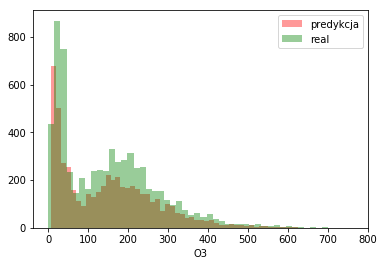

In [15]:
# trzy-ficzerowa

def get_reg(trees_df):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['OBWOD', 'OBWOD_SQ', 'KORONA_NORM']],
        trees_df['O3'],
        test_size=0.2,
    )

    reg = LinearRegression()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(mean_abs_err)
    
    print(r2_score(y_validation, reg.predict(x_validation)))

    return reg, x_train

reg_o3, x_train = get_reg(trees)

a1, a2, a3, b = reg_o3.coef_[0], reg_o3.coef_[1], reg_o3.coef_[2], reg_o3.intercept_

fn = a1 * trees['OBWOD'] + a2 * trees['OBWOD_SQ'] + a3 * trees['KORONA_NORM'] + b

sns.distplot(reg_o3.predict(x_train), kde=False, bins=50, color='r', label='predykcja')
sns.distplot(trees['O3'], kde=False, bins=50, color='g', label='real')
plt.legend()


MErr: 19.1064630936091
R2:   0.9218135043692506


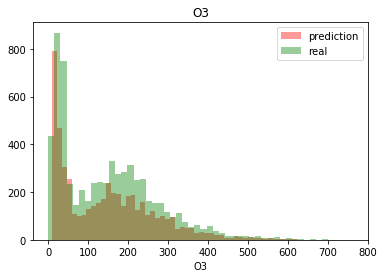

MErr: 11.228233085104925
R2:   0.921435108595306


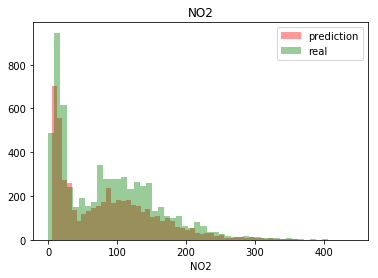

MErr: 1.5943174332074188
R2:   0.9088633129463398


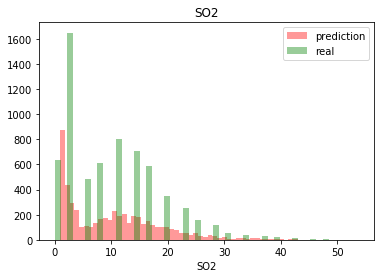

MErr: 1.316077119247622
R2:   0.9066145425850887


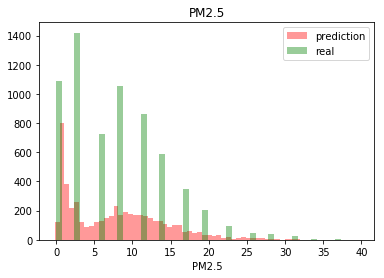

In [90]:
def get_reg(trees_df, factor):
    x_train, x_validation, y_train, y_validation = train_test_split(
        trees_df[['OBWOD', 'OBWOD_SQ']],
        trees_df[factor],
        test_size=0.2,
        random_state=52,
    )

    reg = HuberRegressor()
    reg.fit(
        x_train,
        y_train,
    )
    mean_abs_err = mean_absolute_error(y_train, reg.predict(x_train))
    print(f'MErr: {mean_abs_err}')
    print(f'R2:   {r2_score(y_validation, reg.predict(x_validation))}')
    
    sns.distplot(reg.predict(x_train), kde=False, bins=50, color='r', label='prediction')
    sns.distplot(trees_df[factor], kde=False, bins=50, color='g', label='real')
    plt.title(factor) 
    plt.legend()
    plt.show()
    
    return reg

factors = ['O3', 'NO2', 'SO2', 'PM2.5', ]
models = {}

for factor in factors:

    reg = get_reg(trees, factor)

    models[factor] = reg
    


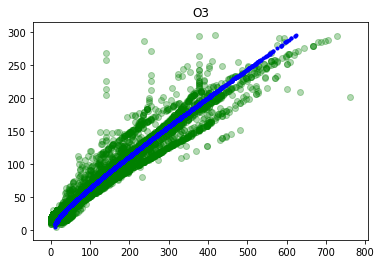

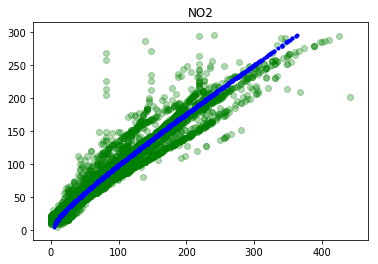

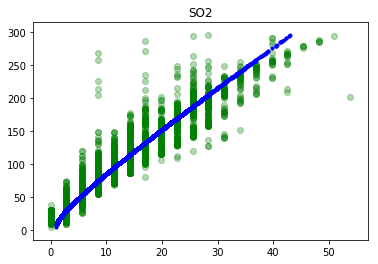

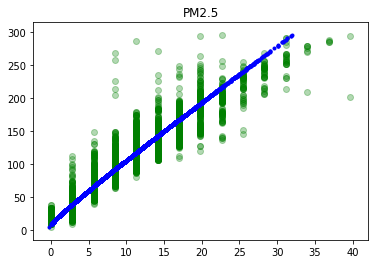

In [91]:
def plot_regression(reg, trees_df, factor):
    a1, a2, b = reg.coef_[0], reg.coef_[1], reg.intercept_

    fn = a1 * trees_df['OBWOD'] + a2 * trees_df['OBWOD_SQ'] + b
    plt.plot(fn, trees_df['OBWOD'], 'b.')
    plt.scatter(trees_df[factor], trees_df['OBWOD'], c='g', alpha=0.3)
    plt.title(factor)
    plt.show()
    
    
for factor, reg in models.items():
    plot_regression(reg, trees, factor)

In [69]:
import math

data['OBWOD'] = data['normalized_trunk_diam'] * math.pi
data['OBWOD_SQRT'] = np.sqrt(data['OBWOD'])

In [92]:
for factor, reg in models.items():
    data[factor] = reg.predict(data[['OBWOD', 'OBWOD_SQRT']])

In [93]:
data.describe()

,gtype,height,width,x,y,normalized_trunk_diam,trunk_diam_sqrt,O3_pred,OBWOD,OBWOD_SQRT,O3,NO2,SO2,PM2.5
count,192618.0,26237.000000,192618.000000,1.926180e+05,1.926180e+05,192618.000000,192618.000000,192618.000000,192618.000000,192618.000000,192618.000000,192618.000000,192618.000000,192618.000000
mean,2001.0,5.841072,1.761398,7.501894e+06,5.787670e+06,26.816123,4.786698,150.439987,84.245335,8.484202,150.439987,87.572388,10.474384,7.856514
std,0.0,12.874934,1.004088,5.092530e+03,5.059696e+03,20.985967,1.975769,140.254154,65.929361,3.501959,140.254154,81.663167,9.632465,7.317045
min,2001.0,0.000000,1.000000,7.490153e+06,5.774696e+06,0.000000,0.000000,9.744747,0.000000,0.000000,9.744747,5.290806,0.944362,-0.304121
25%,2001.0,0.000000,1.000000,7.499040e+06,5.784343e+06,9.867606,3.141275,39.883196,31.000000,5.567764,39.883196,23.161190,2.896480,2.015303
50%,2001.0,4.000000,1.000000,7.501588e+06,5.788131e+06,22.918312,4.787307,116.615166,72.000000,8.485281,116.615166,67.975923,8.114455,6.287061
75%,2001.0,9.000000,2.000000,7.503962e+06,5.791166e+06,38.197186,6.180387,218.280609,120.000000,10.954451,218.280609,127.180734,15.092793,11.606675
max,2001.0,1402.000000,9.000000,7.517461e+06,5.800702e+06,707.284567,26.594822,5569.860471,2222.000000,47.138095,5569.860471,3232.108610,386.780361,268.774614


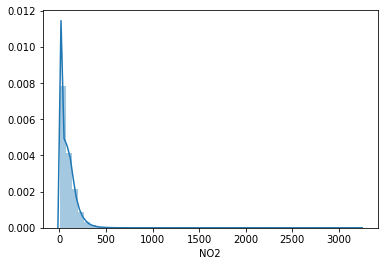

In [95]:
sns.distplot(data['NO2'], bins=50)

In [96]:
data.head()

,Aktualność danych na dzień,Jednostka zarządzająca,Nazwa polska,Nazwa łacińska,Numer inwentaryzacyjny,Obwód pnia w cm,Wysokość w m,gtype,height,id,...,norm,normalized_trunk_diam,trunk_diam_sqrt,O3_pred,OBWOD,OBWOD_SQRT,O3,NO2,SO2,PM2.5
0,24.04.2012,Dzielnica Targówek,robinia sp.,Robinia sp.,D253003,98,14,2001.0,NaN,AAKG9OAAnAAF1O1AAG,...,98,31.194369,5.585192,170.724441,98.000000,9.899495,170.724441,99.498761,11.823883,9.142689
1,24.04.2012,Dzielnica Targówek,robinia sp.,Robinia sp.,D253005,"17, 9, 8, 10, 11",5,2001.0,NaN,AAKG9OAAnAAF1O1AAI,...,"17, 9, 8, 10, 11",8.146495,2.854206,31.314858,25.592968,5.058949,31.314858,18.134354,2.322307,1.493700
2,24.04.2012,Dzielnica Targówek,robinia sp.,Robinia sp.,D253007,20,5,2001.0,NaN,AAKG9OAAnAAF1O1AAK,...,20,6.366198,2.523133,23.208277,20.000000,4.472136,23.208277,13.365426,1.783970,0.974521
3,24.04.2012,Dzielnica Targówek,robinia sp.,Robinia sp.,D253006,30,4.5,2001.0,NaN,AAKG9OAAnAAF1O1AAJ,...,30,9.549297,3.090194,38.253976,30.000000,5.477226,38.253976,22.206131,2.787016,1.917636
4,24.04.2012,Dzielnica Targówek,robinia sp.,Robinia sp.,D253004,"120, 10, 11, 8",14,2001.0,NaN,AAKG9OAAnAAF1O1AAH,...,"120, 10, 11, 8",38.573327,6.210743,220.870749,121.181682,11.008255,220.870749,128.687979,15.271003,11.739985
